#### A NLP project that estimates the sentiment scores of ABC news headlines over years using Affinn lexicon

In [1]:
#import libraries
library(tidyverse)
library(ggplot2)
library(reshape2)
library(quanteda) # install.packages("quanteda")
library(wordcloud2)
library(RColorBrewer)
library(tidytext)
library(grid)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.1.1       v purrr   0.3.2  
v tibble  2.1.1       v dplyr   0.8.0.1
v tidyr   0.8.3       v stringr 1.4.0  
v readr   1.3.1       v forcats 0.4.0  
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Attaching package: 'reshape2'

The following object is masked from 'package:tidyr':

    smiths

Warning message:
"package 'quanteda' was built under R version 3.6.3"Package version: 3.0.0
Unicode version: 10.0
ICU version: 61.1
Parallel computing: 12 of 12 threads used.
See https://quanteda.io for tutorials and examples.


In [2]:
#import data
raw_data <- read_csv('./abc_news_headlines.csv')
head(raw_data)

Parsed with column specification:
cols(
  publish_date = col_double(),
  headline_text = col_character(),
  likes_count = col_double(),
  comments_count = col_double(),
  shares_count = col_double(),
  love_count = col_double(),
  wow_count = col_double(),
  haha_count = col_double(),
  sad_count = col_double(),
  thankful_count = col_double(),
  angry_count = col_double(),
  fakeAccountComments = col_double(),
  chngId = col_double()
)


publish_date,headline_text,likes_count,comments_count,shares_count,love_count,wow_count,haha_count,sad_count,thankful_count,angry_count,fakeAccountComments,chngId
20030219,aba decides against community broadcasting licence,1106,118,109,155,6,5,2,0,6,0,0
20030219,act fire witnesses must be aware of defamation,137,362,67,0,0,0,0,0,0,0,0
20030219,a g calls for infrastructure protection summit,357,119,212,0,0,0,0,0,0,0,0
20030219,air nz staff in aust strike for pay rise,826,254,105,105,21,45,7,0,90,0,0
20030219,air nz strike to affect australian travellers,693,123,153,17,113,4,103,0,7,0,0
20030219,ambitious olsson wins triple jump,488,57,161,0,0,0,0,0,0,0,0


In [3]:
#have a look at the feature statistics
summary(raw_data)

  publish_date      headline_text       likes_count      comments_count    
 Min.   :20030219   Length:1226258     Min.   :      0   Min.   :     0.0  
 1st Qu.:20070525   Class :character   1st Qu.:    295   1st Qu.:    40.0  
 Median :20110511   Mode  :character   Median :    804   Median :   110.0  
 Mean   :20108748                      Mean   :   3218   Mean   :   445.6  
 3rd Qu.:20141129                      3rd Qu.:   2454   3rd Qu.:   316.0  
 Max.   :20201231                      Max.   :1539517   Max.   :770366.0  
  shares_count       love_count          wow_count          haha_count      
 Min.   :      0   Min.   :     0.00   Min.   :    0.00   Min.   :    0.00  
 1st Qu.:     53   1st Qu.:     0.00   1st Qu.:    0.00   1st Qu.:    0.00  
 Median :    166   Median :     0.00   Median :    0.00   Median :    0.00  
 Mean   :   1096   Mean   :    73.78   Mean   :   27.78   Mean   :   35.68  
 3rd Qu.:    561   3rd Qu.:     3.00   3rd Qu.:    2.00   3rd Qu.:    1.00  
 Max. 

In [4]:
#check if there is any missing values
colnames(raw_data)[apply(raw_data, 2, anyNA)]

[1] "headline_text"

##### As can be observed that the data contains number of count of different reaction to the headlines, this will be used to pre-determine people's emotion to the news.
##### 1. Positive emotion will include: likes, love, and thankful
##### 2. Negative emotion will inlude: sad and angry
##### 3. Neutral emotion will include: wow and haha

In [5]:
#remove all the null rows
new_data <- raw_data[complete.cases(raw_data),]
#remove useless columns
new_data <- new_data[c(-12,-13)]
#add column for year and month
new_data$year_month <- substring(new_data$publish_date, 1, 6)
#add column for year
new_data$year <- substring(new_data$publish_date, 1, 4)
#add column for month
new_data$month <- substring(new_data$publish_date, 5, 6)
#define postivie emotion
new_data$positive_emotion <- new_data$likes_count + new_data$love_count + new_data$thankful_count
#define negative emotion
new_data$negative_emotion <- new_data$angry_count + new_data$sad_count
#define minimum value to be 1
new_data$negative_emotion[new_data$negative_emotion == 0] <- 1
#define nuetral emotion
new_data$neutral_emotion <- new_data$wow_count + new_data$haha_count

head(new_data)

publish_date,headline_text,likes_count,comments_count,shares_count,love_count,wow_count,haha_count,sad_count,thankful_count,angry_count,year_month,year,month,positive_emotion,negative_emotion,neutral_emotion
20030219,aba decides against community broadcasting licence,1106,118,109,155,6,5,2,0,6,200302,2003,02,1261,8,11
20030219,act fire witnesses must be aware of defamation,137,362,67,0,0,0,0,0,0,200302,2003,02,137,1,0
20030219,a g calls for infrastructure protection summit,357,119,212,0,0,0,0,0,0,200302,2003,02,357,1,0
20030219,air nz staff in aust strike for pay rise,826,254,105,105,21,45,7,0,90,200302,2003,02,931,97,66
20030219,air nz strike to affect australian travellers,693,123,153,17,113,4,103,0,7,200302,2003,02,710,110,117
20030219,ambitious olsson wins triple jump,488,57,161,0,0,0,0,0,0,200302,2003,02,488,1,0


In [6]:
#define function to plot the barchart of number of emotion counts over year
emotion_df <- new_data %>% group_by(year) %>% summarise(
    'positive emotion' = sum(positive_emotion),
    'negative emotion' = sum(negative_emotion),
    'neutral emotion' = sum(neutral_emotion))
emotion_df <- melt(emotion_df, id.vars = 'year')
emotion_df <- emotion_df %>% rename('reaction' = 'variable')
plot_all_emotion <- ggplot(emotion_df, aes(year, value/1e6, fill = reaction)) + 
  geom_bar(stat = 'identity', position = 'dodge') +
  ylab('Number of Emotion Counts (Million)') +
  theme_light() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

positive_emotion_df <- new_data %>% group_by(year) %>% summarise(
    'like' = sum(likes_count), 'love' = sum(love_count), 'thankful' = sum(thankful_count))
positive_emotion_df <- melt(positive_emotion_df, id.vars = 'year')
positive_emotion_df <- positive_emotion_df %>% rename('reaction' = 'variable')
plot_positive_emotion <- ggplot(positive_emotion_df, aes(year, value/1e6, fill  =reaction)) + 
  geom_bar(stat = 'identity', position = 'dodge') +
  ylab('Number of Emotion Counts (Million)') + theme_light() + theme(axis.text.x = element_blank())

#remove all the count columns
new_data <- new_data[c(-3:-11, -15:-17)]

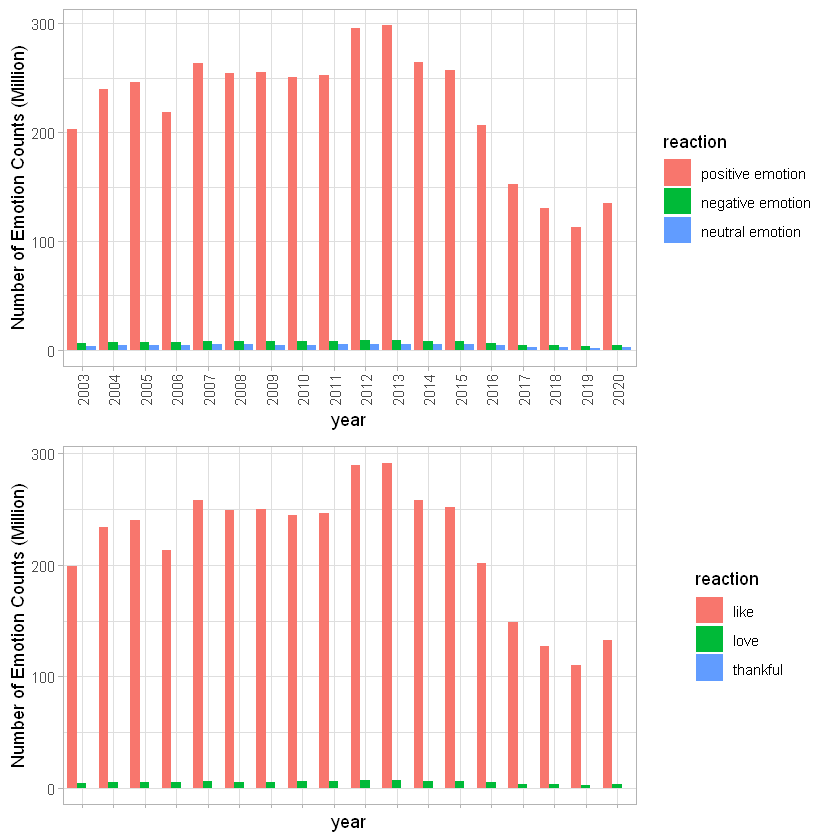

In [7]:
#combine the plots together
grid.newpage()
grid.draw(rbind(ggplotGrob(plot_all_emotion), ggplotGrob(plot_positive_emotion), size = 'first'))

##### The first barchart shows that the defined positive emotion outnumbers the other two emotions for all years. This can be explained by the second barchart as 'like' significantly outnumbers 'love' and 'thankful'. This may imply that when people react to news or even other post using 'like', it does not necessarily mean that they actually like the content of the news. The assumption of positivity of 'like' reaction above is wrong. Hence, the analysis below will use a more proper approach to investigate the sentiment.

In [8]:
#define function to generate corpus from the headline_text column
create_corpus <- function(dataframe){
    #create initial corpus
    corpus <- corpus(dataframe, text_field = 'headline_text') #some unused parameters: remove_twitter = TRUE, tolower = TRUE
    #create cleaned corpus using quanteda
    clean_corpus <- corpus %>%
                    tokens(remove_symbols = TRUE, remove_punct = TRUE, remove_numbers = TRUE) %>%
                    tokens_remove(stopwords("en")) %>%
                    tokens_wordstem()
    return(clean_corpus)
}

In [9]:
#define a function to convert quanteda corpus to dataframe for word frequency
corpus_to_frame <- function(corpus, min_termfreq, min_docfreq){
    #convert corpus to a sparse document-feature matrix
    dfmat <- dfm(corpus)
    #reduce the size of dfm
    trimmed_dfm <- dfm_trim(dfmat, min_termfreq = min_termfreq, min_docfreq = min_docfreq)
    #compute the total frequency of each word within the columns
    frequency <- sort(colSums(as.matrix(trimmed_dfm)), decreasing=TRUE)
    #construct the dataframe
    df <- data.frame(word = names(frequency), freq=frequency, row.names = NULL)
    return(df)
}

In [10]:
#define a smaller dataframe for news headlines
trimmed_data <- new_data[new_data$year>=2019,]
head(trimmed_data)

publish_date,headline_text,year_month,year,month
20190101,after expo ministers approved an artificial island,201901,2019,01
20190101,alyssa healy named worlds best womens t20 player for 2018,201901,2019,01
20190101,australia called a free rider on tackling climate change howard,201901,2019,01
20190101,australia still has no us ambassador,201901,2019,01
20190101,bangladesh ruling coalition declared winner of disputed vote,201901,2019,01
20190101,beyond the toll of northern territory horror roads,201901,2019,01


##### The data is trimmed to show only headlines after 2019 in order to reduce computational complexity for creating corpus

In [11]:
#call the function
small_corpus <- create_corpus(trimmed_data)
new_word_freq_df <- corpus_to_frame(small_corpus, 3, NULL)
head(new_word_freq_df)

word,freq
coronavirus,8383
australia,3154
covid,2713
new,2335
polic,2279
nsw,2243


In [12]:
#construct the word cloud
wordcloud2(data = new_word_freq_df, minRotation = 0, maxRotation = 0, ellipticity = 0.6, size = 0.5)

HTML widgets cannot be represented in plain text (need html)

##### The result of the generated wordcloud is expected as the term 'coronavirus' dominates the headlines between 2019 and 2020. In comparison to the second term 'australia', the frequency of 'coronavirus' is 3000 higher.

In [13]:
#use afin setimental score for this analysis
afin_score <- as.data.frame(get_sentiments("afin"))
head(afin_score)

word,score
abandon,-2
abandoned,-2
abandons,-2
abducted,-2
abduction,-2
abductions,-2


In [14]:
afin_score[afin_score$word=='coronavirus'|afin_score$word=='covid',]

word,score


##### However, when using Afinn lexicon to match the words, there is no result for 'coronavirus' or 'covid', meaning that the sentimental analysis for year 2019 and 2020 will be affected, which is also expected as the lexicon has not been updated yet.

In [15]:
#define a function to output the score for matching headline key words
get_score <- function(dataframe){
    #separate the words in each row into separate row
    expanded_data <- dataframe %>% separate_rows(headline_text) %>% rename(word = headline_text)
    #store the score of matching words
    score_df <- merge(expanded_data, afin_score, by = 'word', all.y = TRUE)
    #remove missing values
    score_df <- score_df[complete.cases(score_df), ]
    return(score_df)
}

In [16]:
#count the number of headlines each month over the years
year_month_count <- new_data %>% count(year_month)
#call the function to output sentiment score
score_df <- get_score(new_data)
#estimate the total sentiment score each month over the eyars
score <- score_df %>% group_by(year_month) %>% summarise(sum = sum(score))
#compute the mean score
score$mean <- score$sum/year_month_count$n

In [17]:
#plot the totoal number of headlines in thousand units each month over the year
plot_all_headlines <- ggplot(year_month_count, aes(year_month, n/1000, group = 1)) + geom_line(col = 'chartreuse4', size = 1) + 
                        theme_light() + ylab('Monthly Number of Headlines (Thousands)') +  
                        scale_x_discrete(breaks = seq(200302, 202012, by = 100)) +
                        theme(axis.text.y = element_text(vjust = 0.5, hjust = 0.3), 
                              axis.text.x = element_text(angle = 60, vjust = 0.5, hjust = 0.5), 
                              axis.title.x = element_blank(),
                              legend.position = "none")

In [18]:
#plot the mean sentiment score each month over the year
plot_all_score <- ggplot(score, aes(year_month, mean, group = 1)) + geom_line(col = 'orange', size = 1) + theme_light() + 
                    scale_x_discrete(breaks = seq(200302, 202012, by = 100)) + ylab('Monthly Mean Sentiment Score') +
                    theme(axis.text.x = element_blank(), 
                          axis.title.x = element_blank(),
                          legend.position = "none")

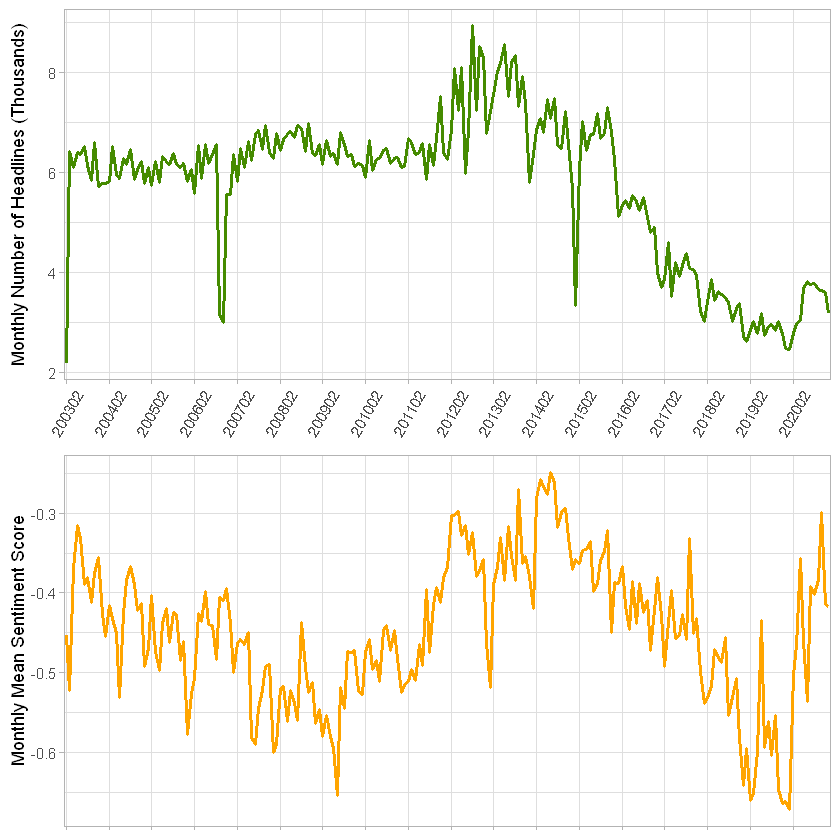

In [19]:
#combine the plots together
grid.newpage()
grid.draw(rbind(ggplotGrob(plot_all_headlines), ggplotGrob(plot_all_score), size = "last"))

##### The changes in number of headlines experiences 3 local minima in 2003, 2006 and 2015. While there are no other evidence provided, the reason can be hardly interpreted, especially for 2003 when they whole world was experiencing SARS pandemic. Moreover, the plot shows decreasing trend after 2015 in comparison to the fluctuation in the previous years in spite of the 3 sharp declines.
##### It is very intersting to observe that all the mean sentiment scores negative. It does not necessarily imply that most of the news were negative but most of the key words used were negative. As people tend to pay more attention to negative things, the media uses such negativity theory to attract more readers.